<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/trabajo_practico_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 2: Ajuste de distribuciones de probabilidad

**Objetivos:** Este trabajo tiene como objetivos familiarizar al alumno con los métodos numéricos para el ajuste de distribuciones de probabilidad con un framework Bayesiano, así como entender el efecto de la incertidumbre de los parametros estimados en las predicciones y el análisis de datos

**Librerías:** para realizar este trabajo serán necesarias las siguientes librerías (Si requiere usar otras no incluidas aquí, no dude en importarlas)
- Numpy: matemática básica y definición de matrices y vectores
- Scipy.stats: repositorio de distribuciones de probabilidad y funciones de algebra
- Pandas: manejo de datasets
- Seaborn: visualización de datos
- pymc: inferencia bayesiana

In [ ]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
# !pip install pymc
import pymc as pm
import arviz as az

In [ ]:
def qqplot(x,y):
# FUNCION PARA GRAFICAR QQ-PLOTS
# x es el vector con los datos obtenidos mediante simulacion
# y es el vector con los datos muestras
# La funcion asume que el vector x tiene más elementos que el vector y

  from scipy.interpolate import interp1d
  from statsmodels.distributions.empirical_distribution import ECDF
  # Funciones acumuladas empíricas
  CDFx = ECDF(x)
  CDFy = ECDF(y)

  # Factores de Correccion
  Nx = len(CDFx.x)-1
  CDFx.y = CDFx.y*Nx/(Nx+1)
  Ny = len(CDFy.x)-1
  CDFy.y = CDFy.y*Ny/(Ny+1)

  # Interpolación lineal para CDFx
  CDFx_interp = interp1d(CDFx.y[1:],CDFx.x[1:])

  # Cuantiles de Y
  Qy = CDFy.x[1:]
  # Encontrar los cuantiles de de x asociados a los de y
  Qx = np.zeros(len(Qy))
  for i in range(len(Qy)):
    Qx[i] = CDFx_interp(CDFy.y[i+1])

  # Datos para el grafico
  xmin = np.min([np.min(Qx),np.min(Qy)]) 
  xmax = np.max([np.max(Qx),np.max(Qy)])

  # Plot
  fig = plt.figure(figsize=(5,5))
  plt.scatter(Qx,Qy)
  plt.plot([xmin,xmax],[xmin,xmax],'k-')
  plt.grid()
  plt.xlabel('Cuantiles Simulación')
  plt.ylabel('Cuantiles Muestras')
  plt.show()

## Ejercicio 1: Evaluación de un tratamiento para el hormigón

Una empresa constructora quiere evaluar un nuevo proceso de curado y ver si tiene un efecto en la resistencia del hormigón. Para ello se tienen 7 pares de ensayos de probetas, con y sin tratamiento. Se considerará un efecto significativo si la resistencia del hormigón aumenta por encima de los 2MPa por sobre el hormigón sin tratamiento.

El objetivo de este ejercicio es afirmar si esto es cierto a partir de un enfoque probabilístico.

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving hormigon_tratamiento_tp2.csv to hormigon_tratamiento_tp2 (1).csv


In [ ]:
#Se crea un DataFrame
df = pd.read_csv(io.BytesIO(uploaded['hormigon_tratamiento_tp2.csv']))
df.head()

,sin-tratamiento,con-tratamiento
0,30.9,34.2
1,33.3,37.1
2,33.5,39.6
3,36.2,40.3
4,37.2,40.5


**ITEM**: Primero calcule el valor medio y el desvío estandar (muestral) de los hormigones con y sin tratamiento.

In [ ]:
# Cantidad de muestras
N = len(df)
print('Numero de muestras',N)

# Hormigón sin tratar
# CODIGO DEL ALUMNO ============================================================
h0_mean = []
h0_std = []
# ==============================================================================

# Hormigón con tratamiento
# CODIGO DEL ALUMNO ============================================================
h1_mean = []
h1_std = []
# ==============================================================================

print('Sin Tramiento')
print('Media',h0_mean,'desvio',h0_std)
print('Con Tratamiento')
print('Media',h1_mean,'desvio',h1_std)

Numero de muestras 7
Sin Tramiento
Media 35.271428571428565 desvio 2.7299049346783053
Con Tratamiento
Media 39.699999999999996 desvio 3.234192325759245


Debiera ver una diferencia de más de $4MPa$ en el valor medio. ¿Eso alcanza para asegurar con cierto margen de confianza que la diferencia es mayor a $2MPa$?

### Función predictiva para cada hormigón

Para contestar esta pregunta, primero necesitamos un modelo de generación de datos para las resistencias del hormigón con y sin tratamiento.

**ITEM**: Asumiendo una distribución a priori no informativa y un modelo de generación de datos Normal, escriba la distribución predictiva (usando la librería scipy.stats) `h0_pred` y `h1_pred` para el homigón sin y con tratamiento, respectivamente.

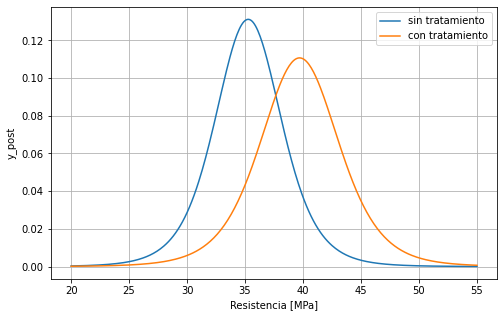

In [ ]:
# Predictiva de las resistencias
# CODIGO DEL ALUMNO ============================================================
h0_pred = []
h1_pred = []
# ==============================================================================

x = np.linspace(20,55,351)
fig = plt.figure(figsize=(8,5))
plt.plot(x,h0_pred.pdf(x),label='sin tratamiento')
plt.plot(x,h1_pred.pdf(x),label='con tratamiento')
plt.grid()
plt.xlabel('Resistencia [MPa]')
plt.ylabel('y_post')
plt.legend()
plt.show()

###Comparación de Resistencias características:

Usted podría ver el dato de valor medio y decir "Claro, pero en realidad lo que hay que comparar son las resistencias características, no considerás el desvío sino". Probemos:

**ITEM**: Calcule las resistencias características de cada uno de los hormigones con el criterio de 90% de probabilidad de excedencia.

In [ ]:
# CODIGO DEL ALUMNO ============================================================
fc0 = []
fc1 = []
# ==============================================================================

print('Sin tratamiento:', fc0,'MPa')
print('Con tratamiento:', fc1,'MPa')

Sin tratamiento: 31.069658165550518 MPa
Con tratamiento: 34.722048779550455 MPa


La diferencia es también de prácticamente $4MPa$. Pero esto no necesariamente implica, con certeza, que la resistencia de cualquier hormigón con el tratamiento sea, por lo menos 2MPa, que cualquier hormigón sin tratamiento.

Para esto necesito comparar toda la distribución de probabilidad de la resistencia de cada hormigón, y no simplemente sus valores medios o sus valores característicos.

Veremos ahora que son cosas muy distintas.

### Diferencia entre hormigones
Lo que nos interesa saber es si se puede afirmar con una probabilidad suficientemente alta (digamos, 90%) que la resistencia del hormigón (de una probeta cualquiera) con tratamiento supera en $2MPa$ al caso sin tratamiento.

Para ello necesitaríamos la función de distribución de la diferencia entre hormigones, para luego calcular la probabilidad de que la diferencia sea mayor a 2. Sin embargo, no hay una solución analítica para la resta de dos t-Student.

Por eso, usted va a resolver este problema mediante simulación de montecarlo:

**ITEM**: Los pasos son:
1. Mediante simulación, simule valores de resistencia de los hormigones sin y con tratamiento, y guarde valores simulados de la diferencia en `rdiff`
2. Calcule, mediante conteo, la probabilidad de que el hormigón con tratamiento sea $2MPa$ más resistente que el hormigón sin tratamiento.
3. ¿Considera esa probabilidad suficiente para aceptar la información provista por el fabricante?

La probabilidad de que el hormigón con tratamiento sea 2MPa más resistente es 0.681


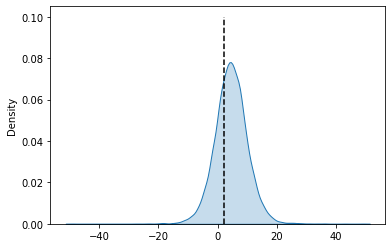

In [ ]:
# Distribución de la diferencia
Nsim = 20000

# Generar simulaciones de la diferencia

# CODIGO DEL ALUMNO ============================================================
r1_post = []
r2_post = []
rdiff = r2_post - r1_post
# ==============================================================================

# Probabilidad de que h2 - h1 > 2

# CODIGO DEL ALUMNO ============================================================
Pefecto = []
# ==============================================================================

print('La probabilidad de que el hormigón con tratamiento sea 2MPa más resistente es',Pefecto)

fig, ax = plt.subplots()
sns.kdeplot( rdiff, fill=True )
ax.vlines( x=2, ymin=0, ymax=0.1, linestyle='--' )
plt.show()

**Su respuesta**:

## Ejercicio 2: Período de retorno de lluvias en CABA

En el segundo ejercicio queremos obtener el período de retorno de las precipitaciones en CABA. Es decir, "cada cuántos años en promedio llueve $x\ mm$ o más" en un mes en la ciudad.

Para ello tenemos un dataset de $mm$ de lluvia mensuales en la ciudad desde 1991. A lo largo del ejercicio usted hará el curado de la información y luego la inferencia para llegar al resultado final.

###Curado del dataset

Primero, importe el archivo `historico_precipitaciones-CABA.csv` en Google Colab.

In [ ]:
# Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving historico_precipitaciones-CABA.csv to historico_precipitaciones-CABA.csv


In [ ]:
# Se crea un DataFrame
df = pd.read_csv(io.BytesIO(uploaded['historico_precipitaciones-CABA.csv']))
df.head()

,ano,mes,mm,dias
0,1991,Enero,190.0,7
1,1991,Febrero,30.5,6
2,1991,Marzo,55.0,8
3,1991,Abril,125.6,12
4,1991,Mayo,68.4,7


Con los datos de arriba se puede generar una nueva columna que sea la fecha introducida en formato `datetime`.

In [ ]:
# Crear columna con datetime
lista_meses = df['mes'].unique()
mes_num = df.apply (lambda row: np.where(row['mes']==lista_meses)[0][0]+1, axis=1)
df['fecha'] = pd.to_datetime(df['ano'].astype(str) + mes_num.astype(str), format='%Y%m')
df = df.set_index('fecha')
df.head()

,ano,mes,mm,dias
fecha,,,,
1991-01-01,1991,Enero,190.0,7
1991-02-01,1991,Febrero,30.5,6
1991-03-01,1991,Marzo,55.0,8
1991-04-01,1991,Abril,125.6,12
1991-05-01,1991,Mayo,68.4,7


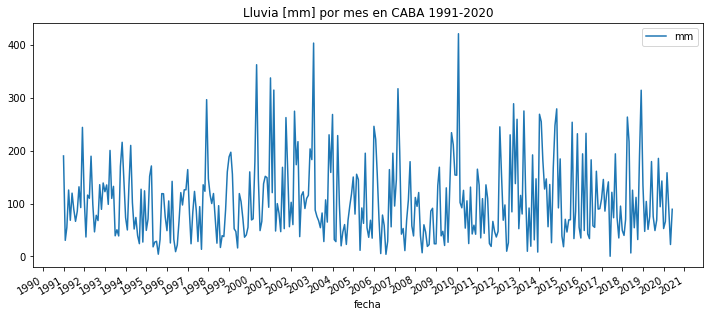

In [ ]:
import matplotlib.dates as mdates
# Grafico
ax = df.plot( y='mm', figsize=(12,5), x_compat=True )
ax.xaxis.set_major_locator(mdates.YearLocator()) # Poner labels solo en cada año
ax.xaxis.set_major_formatter( mdates.DateFormatter("%Y") ) # Formatear label
plt.title('Lluvia [mm] por mes en CABA 1991-2020');

**ITEM**: Dado el dataframe `df`, defina un nuevo dataframe `yearly_max` que en vez de incluir las lluvias mensuales, agrupe por año calendario la máxima lluvia mensual registrada

PISTA: Para los primeros 5 años debieran ver que el dataframe contiene los datos del mes de septiembre

In [ ]:
# Datafarme de maximos anuales

# CODIGO DEL ALUMNO ============================================================
yearly_max = []
# ==============================================================================

yearly_max.head()

,ano,mes,mm,dias
fecha,,,,
1991-12-31,1991,Septiembre,244.0,16
1992-12-31,1992,Septiembre,189.5,16
1993-12-31,1993,Septiembre,215.8,14
1994-12-31,1994,Septiembre,209.9,17
1995-12-31,1995,Septiembre,171.1,13


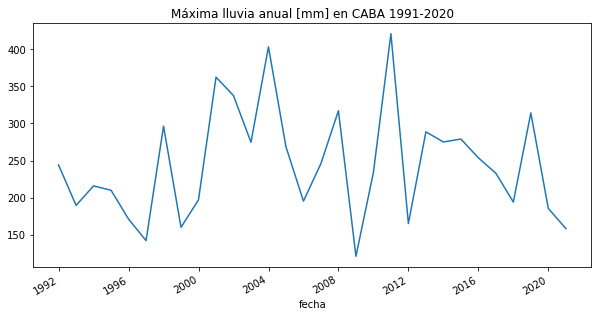

In [ ]:
# Grafico
ax = yearly_max.plot( y='mm', legend=False, figsize=(10,5), x_compat=True )
ax.xaxis.set_major_formatter( mdates.DateFormatter("%Y") ) # Formatear label # Formatear labels
plt.title('Máxima lluvia anual [mm] en CABA 1991-2020');

**ITEM**: Haga un histograma para la lluvia máxima mensual en términos de probabilidad. Elija un numero de bins que considere apropriado.

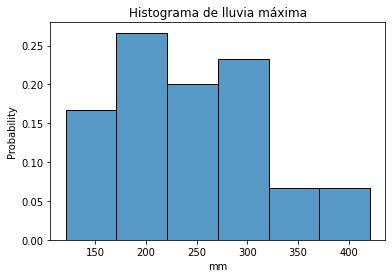

245.07 75.53755015062787


In [ ]:
# Histograma
# CODIGO DEL ALUMNO ============================================================

# ==============================================================================

plt.show()
print( yearly_max['mm'].mean(), yearly_max['mm'].std() )

###Ajuste de una función de distribución para la máxima lluvia acumulada mensual por año

En este paso usted ajustará una función de distribucón para la máxima lluvia mensual en un año. Dado que es un problema de extremos, y visto el histograma que usted generó, se considera apropiado tomar como modelo la distribución de máximo de Tipo I, conocida como distribución de Gumbel:

$$p(y|\mu,\beta) = e^{-\frac{x-\mu}{\beta}-e^{-\left(\frac{x-\mu}{\beta}\right)}}$$

A la cual le debemos ajustar los parámetros $\mu$ y $\beta$. La distribución de Gumbel **No** tiene una distribución conjugada, por lo que no hay una solución analítica para la distribución a posterior de los parámetros. Tampoco se puede plantear una distribución a priori no-informativa.

En este problema, queda en usted elegir un método de solución numérica y proponer funciones de distribución a priori poco informativas (distribuciones que sean razonablemente planas dentro del rango de valores que puedan llegar a tener las variables). Queda en usted probar posibles funciones y asegurarse que su elección de distribución a priori no está afectando la inferencia*.

*NOTA: Asumiendo que es lo que usted quiere. ¡Si tiene información que quiere introducir en el modelo es bienvenido!

Los datos observados vamos a ubicarlos en la variable `y`

In [ ]:
# Observaciones
y = yearly_max['mm']

**ITEM**: Obtenga la distribución posterior de los parámetros $\mu$ y $\beta$ por el método que le guste. Grafíquelas, y calcule para cada una su valor medio y un intervalo de confianza que le parezca razonable.

In [ ]:
# CODIGO DEL ALUMNO ============================================================

# ==============================================================================

**ITEM**: A partir de las distribuciones posteriores de los parámetros, realice simulaciones posteriores predictivas de nuevas observaciones $y$ y guardelas en la variable `y_post`

In [ ]:
Npred = 5000

# CODIGO DEL ALUMNO ===========================================================

y_post = []
# ==============================================================================

###Evaluación
Teniendo el vector `y_post` con las simulaciones del modelo ajustado, abajo puede ver el qq-plot.

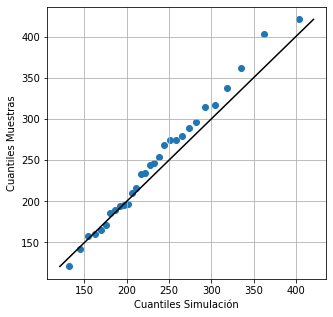

In [ ]:
qqplot(y_post,y)

**ITEM**: ¿El modelo elegido se ajusta a los datos observados?

**Su respuesta**: 

###Periodo de Retorno
Ya con el vector `y_post`, para definir el período de retorno es necesario construir la función de probabilidad acumulada empírica.

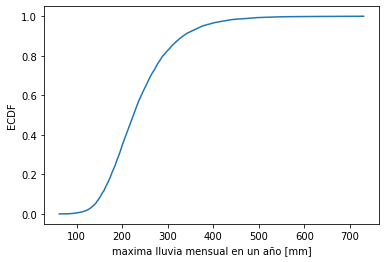

In [ ]:
# CODIGO DEL ALUMNO ============================================================

# abcisas
xecdf = []
# ordenadas
yecdf = []
# ==============================================================================

plt.plot(xecdf,yecdf)
plt.xlabel('maxima lluvia mensual en un año [mm]')
plt.ylabel('ECDF')
plt.show()

El período de retorno $T(x)$ es el tiempo promedio $T$ entre eventos que superan determinado valor de la variable $x$:

$$T(x) = \frac{1}{1-p(X\leq x)}$$

lo que considera que el tiempo promedio es la inversa de la probabilidad de excedencia.

**ITEM**: En base a los datos, grafique el período de retorno para la máxima lluvia mensual en un año `Tr`:

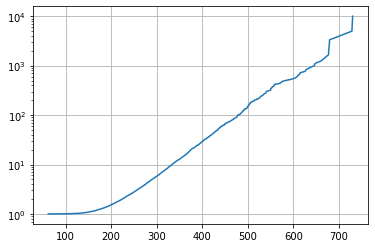

In [ ]:
# Periodo de retorno

# CODIGO DEL ALUMNO ============================================================
Tr = []

# ==============================================================================
plt.show()

**ITEM**: ¿Cuál es la máxima lluvia mensual para un período de retorno de 100 años? (Sea conservador)

In [ ]:
# CODIGO DEL ALUMNO ============================================================
Tmax = []

# ==============================================================================

print('La máxima lluvia mensual con período de retorno 100 años es',Tmax,'mm')

La máxima lluvia mensual con período de retorno 100 años es 478.46407079410267 mm


##Ejercicio 3: Inferencia sobre el dataset escogido en el TP1

Vuelva al dataset que usted eligió para el TP1. Elija una de las variables del dataset y:

*   Proponga un modelo posible de generación de datos según su Análisis Exploratorio de Datos,
*   Ajuste su modelo mediante el método que prefiera,
*   Evalue su ajuste a partir de simulación y comparando las ECDF y utilizando QQ-plots.